Prototype stopped: Performance too bad.

# Sentiment Analysis Prototyping

Prototype code for ML-based sentiment analysis. Classification case neg/non-negative only.

In [1]:
import os, sys, re, string, pickle, random
sys.path.append("..")
from config import credentials
import dropbox

import numpy as np
import pandas as pd

import spacy

import emoji

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, LeaveOneOut
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, PrecisionRecallCurve, ROCAUC

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
random_state = 23
random.seed(random_state)

## Loading

In [3]:
team_dbx = dropbox.DropboxTeam(credentials.dropbox_team_access_token)
team_root = team_dbx.with_path_root(dropbox.common.PathRoot.namespace_id(
    credentials.dropbox_team_namespace_id))
user_dbx = team_root.as_user(credentials.dropbox_team_member_id)

data_path = "/Data/CSVData"
fpath = os.path.join(data_path, "TestData", "forSentAnalysis.csv")

_, res = user_dbx.files_download(fpath)
labeled_data = pd.read_csv(res.raw)
labeled_data.shape

(1342, 7)

Rating schema: {0: "positive", 10: "neutral", 20: "negative", 30: "offensive", -2: "notAssessable"}

## Preprocessing

Dataset cleansing

In [4]:
# Remove unnecessary cols and rename them uniformly
labeled_data.drop(["id", "Level", "Topic", "sentiment"], axis=1, inplace=True)
labeled_data.columns = ["source", "text", "rating"]

# Remove not assessable
labeled_data = labeled_data[labeled_data.rating != -2]

# Remove empty texts
labeled_data.text.replace("", np.nan, inplace=True)
labeled_data.dropna(subset=["text"], inplace=True)
labeled_data = labeled_data[~labeled_data.text.str.isspace()]

# Remove duplicated texts
labeled_data.drop_duplicates(subset=["text"], keep="first", inplace=True)

# Remap rating labels
new_rating_schema = {0: 1, 10: 1, 20:-1, 30:-1}
labeled_data.rating = labeled_data.rating.map(new_rating_schema)

labeled_data.shape

(1053, 3)

New rating schema: {1: "non-negative", -1: "negative"}

In [5]:
labeled_data.rating.value_counts()

 1    546
-1    507
Name: rating, dtype: int64

## Exploration

NaN Stats

In [6]:
labeled_data.isna().sum()

source    0
text      0
rating    0
dtype: int64

Duplicated texts (after cleaning)

In [7]:
labeled_data.text.duplicated().value_counts()

False    1053
Name: text, dtype: int64

Distribution of sources

In [8]:
print("Sources count:", len(labeled_data.source.value_counts()))
print("Avg count of doc per source:", np.mean(labeled_data.source.value_counts().tolist()))
print("Top 5 sources:")
labeled_data.source.value_counts()[:5]

Sources count: 66
Avg count of doc per source: 15.954545454545455
Top 5 sources:


DIE_KRONE                 111
JOY_PAMELA_RENDIWAGNER    100
DER_STANDARD               71
FLORIAN_KLENK              70
NORBERT_HOFER              60
Name: source, dtype: int64

Distribution of ratings

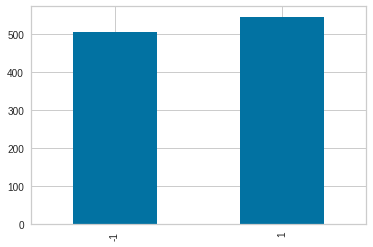

In [9]:
labeled_data.rating.value_counts(sort=False).plot(kind="bar")

-> we have more or less balanced (but generally too less) data.

## Sentiment Assignment

ML-based approach.

### Train/Test-Split

No need for Dev-Set, as we use cross-validation for model tuning.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(labeled_data.text, labeled_data.rating,
                                                    test_size=0.2, stratify=labeled_data.rating, 
                                                    random_state=random_state)

print("X shapes (train/test):", X_train.shape, "/", X_test.shape)
print("y shapes (train/test):", y_train.shape, "/", y_test.shape)

X shapes (train/test): (842,) / (211,)
y shapes (train/test): (842,) / (211,)


### Vectorizer

In [11]:
from spacy_tokenize import spacy_tokenizer

count_vect = CountVectorizer(tokenizer=spacy_tokenizer, max_features=4500)

### Models

In [12]:
logreg = LogisticRegression(solver="liblinear", max_iter=4000, random_state=random_state, n_jobs=1)
nb = MultinomialNB()

models = [logreg, nb]

Parameters

In [13]:
params = {}
params["LogisticRegression"] = {"penalty": ["l2"],
                                "dual": [False, True],
                                "C": [0.5, 1., 10., 20.]}
params["MultinomialNB"] = {"alpha": [1.0e-10, 1.0e-9, 1.],
                           "fit_prior": [True, False]}

### Pipeline

In [14]:
classifiers = {}
scoring = "f1"

for model in models:
    classifiers[type(model).__name__ + "_pipe"] = Pipeline([
        ("count_vect", count_vect),
        ("clf", GridSearchCV(model, param_grid=params[type(model).__name__],
                             scoring=scoring, cv=8, refit=True, n_jobs=-1))
    ])

Train

In [15]:
for _, clf_pipeline in classifiers.items():
    clf_pipeline.fit(X_train, y_train)

Score

In [16]:
best_score = 0
best_model_pipe = None # = best generalization

for name, clf_pipeline in classifiers.items():
    y_pred = clf_pipeline.predict(X_test)
    scores = cross_validate(clf_pipeline, X_test, y_test, scoring=scoring, cv=8, n_jobs=1)
    mean_score = scores["test_score"].mean()
    mean_fit_time = scores["fit_time"].mean()
    
    print(name)
    print("Test score (mean):", mean_score)
    print("Test fit time (mean):", mean_fit_time)
    print("Train score:", clf_pipeline.named_steps["clf"].best_score_)
    print("Params:", clf_pipeline.named_steps["clf"].best_params_, "\n")
    
    if mean_score > best_score:
        best_model_pipe = clf_pipeline
        best_score = mean_score

LogisticRegression_pipe
Test score (mean): 0.6267930245574932
Test fit time (mean): 0.2458558976650238
Train score: 0.6469982097775235
Params: {'C': 0.5, 'dual': False, 'penalty': 'l2'} 

MultinomialNB_pipe
Test score (mean): 0.6500003157761778
Test fit time (mean): 0.15920591354370117
Train score: 0.62137284260612
Params: {'alpha': 1e-10, 'fit_prior': True} 



In [17]:
#len(best_model_pipe.named_steps["count_vect"].get_feature_names())
#best_model_pipe.named_steps["count_vect"].vocabulary_

## Evaluation

In [18]:
print("Best pipeline CLF:", best_model_pipe.named_steps["clf"].best_estimator_)

Best pipeline CLF: MultinomialNB(alpha=1e-10, class_prior=None, fit_prior=True)


In [19]:
class_encoding = {1: "non-negative", -1: "negative"}

#### Confusion Matrix

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


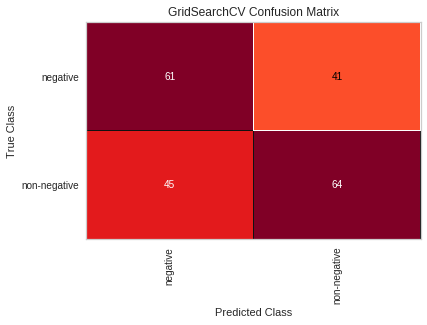

In [20]:
cm = ConfusionMatrix(best_model_pipe, is_fitted=True, encoder=class_encoding)
cm.score(X_test, y_test)
cm.poof()

#### Classification Report

              precision    recall  f1-score   support

          -1       0.58      0.60      0.59       102
           1       0.61      0.59      0.60       109

    accuracy                           0.59       211
   macro avg       0.59      0.59      0.59       211
weighted avg       0.59      0.59      0.59       211



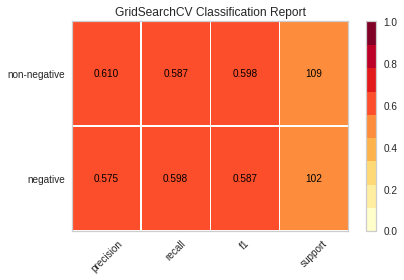

In [21]:
print(classification_report(y_test, best_model_pipe.predict(X_test)))

# Visualizer
report = ClassificationReport(best_model_pipe, is_fitted=True, encoder=class_encoding, support=True)
report.score(X_test, y_test)
report.poof()

#### Precision-Recall Curve

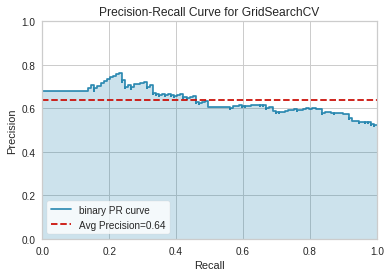

In [22]:
pr_curve = PrecisionRecallCurve(best_model_pipe)
pr_curve.fit(X_train, y_train)
pr_curve.score(X_test, y_test)
pr_curve.poof()

#### ROCAUC

/home/datadonk23/anaconda3/envs/WBNRW19/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


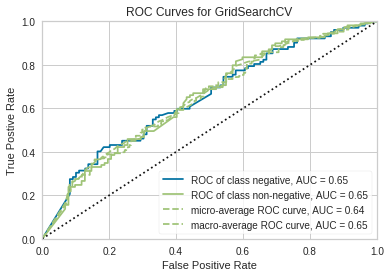

In [23]:
rocauc = ROCAUC(best_model_pipe, is_fitted=True, encoder=class_encoding)
rocauc.score(X_test, y_test)
rocauc.poof()

# Conclusion

Spacy-based preprocessing leads to slightly better performance of the model. Nonetheless, it is still far too bad for production use.